In [174]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Analysis of NCMC parameter exploration
For a fixed chemical potential, the number of kernels and velocity Verlet steps were changed to observe the effects on the acceptance probability. 

First, defining a function to read the simulation data.

In [175]:
def readdata(filename):
    filelines = open(filename).readlines()
    Nwats = []
    Nsalt = []
    Accprob = []
    time = []
    i=3
    step = int(filelines[i][0:5].strip())
    while i-3 == step:
        Nwats.append(int(filelines[i][6:10].strip()))
        Nsalt.append(int(filelines[i][15:18].strip()))
        Accprob.append(float(filelines[i][19:24].strip()))
        time.append(int(filelines[i][24:28].strip()))
        i += 1
        try:
            #print filelines[i]
            step = int(filelines[i][0:5].strip())
        except ValueError:
            break
        except IndexError:
            break
    return np.vstack((np.array(Nwats),np.array(Nsalt),np.array(Accprob),np.array(time)))

Reading in the data:

In [176]:
nkernals = [126,512,1024,2048,4096]
nvsteps = [1,2,4,8,16,32,64]

MeanSalt = np.zeros((len(nkernals),len(nvsteps)))
AccProb = np.zeros((len(nkernals),len(nvsteps)))
MeanTime = np.zeros((len(nkernals),len(nvsteps)))

for i in range(len(nkernals)):
    for j in range(len(nvsteps)):
        filename = 'NCMC_sweep/nk{0}_nV{1}/run1.txt'.format(nkernals[i],nvsteps[j])
        data = readdata(filename)
        MeanSalt[i,j] = data[1].mean()
        AccProb[i,j] = data[2].mean()
        MeanTime[i,j] = data[3].mean()

# 1. Plotting parameter matrices
**Looking at**
* **Acceptance probability**
* **Mean number of salt pairs**
* **Time per kernel**
## Acceptance probability

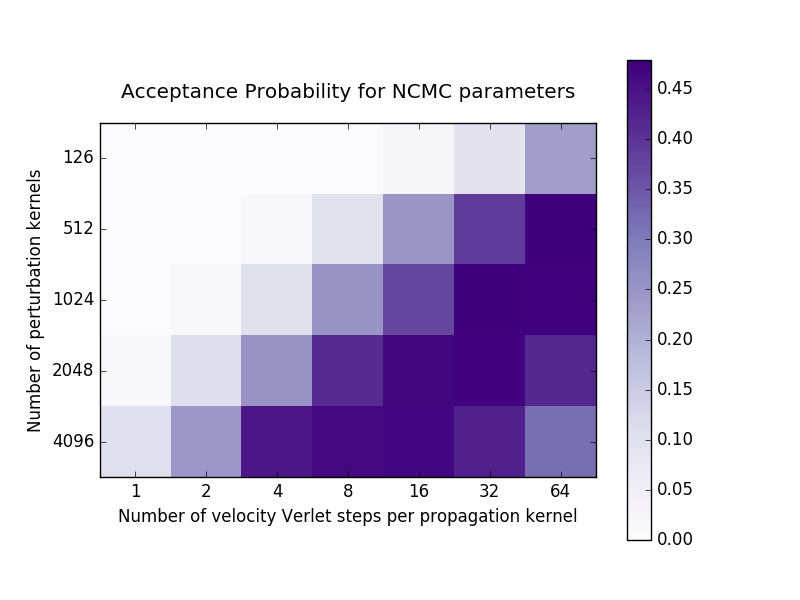

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(AccProb,cmap=plt.cm.Purples,interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+nvsteps)
ax.xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax.set_yticklabels(['']+nkernals)

ax.set_title('Acceptance Probability for NCMC parameters')
ax.set_ylabel("Number of perturbation kernels")    
ax.set_xlabel("Number of velocity Verlet steps per propagation kernel")    
ax.xaxis.set_label_position('bottom') 

#fig.set_title('Acceptance Probability')
plt.savefig("AcceptanceProb.png", format='png')
Image("AcceptanceProb.png")

**SUMMARY**
* The acceptance probability reaches a maximum of just under 50%, not 100% as I expected.
* Increasing the number of velocity Verlet steps is a time efficient (see 'Time per run') way to increase acceptance rates.

## Mean number of salt molecules
It appears that the mean number of salt pairs increases with the computational resource. Depending on whether the number of salt pairs have equilibrated or not, this suggests that the NCMC protocol is not sampling from the same equilibrium distribution.

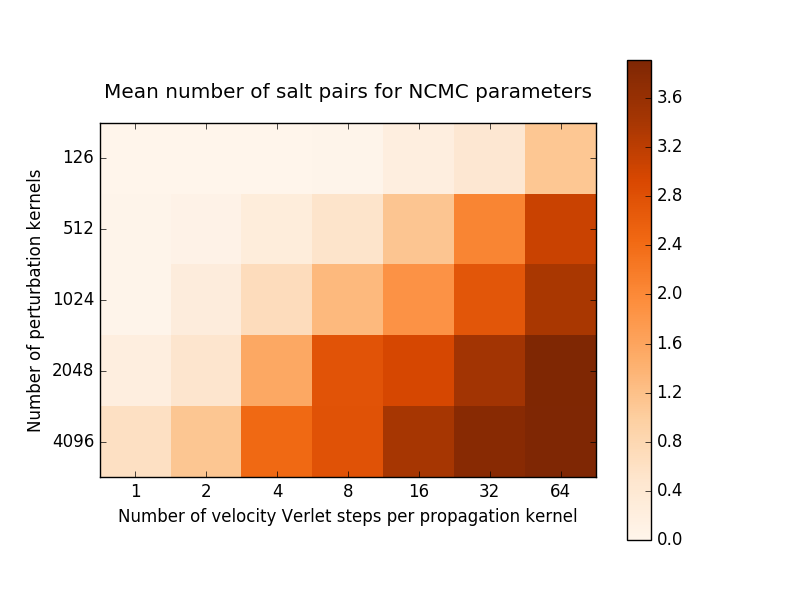

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(MeanSalt,cmap=plt.cm.Oranges,interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+nvsteps)
ax.xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax.set_yticklabels(['']+nkernals)

ax.set_title('Mean number of salt pairs for NCMC parameters')
ax.set_ylabel("Number of perturbation kernels")    
ax.set_xlabel("Number of velocity Verlet steps per propagation kernel")    
ax.xaxis.set_label_position('bottom') 

#fig.set_title('Acceptance Probability')
plt.savefig("NumberSalt.png", format='png')
Image("NumberSalt.png")

**SUMMARY**
* Mean number of salt pairs increases with computational resource.
    * Doesn't appear to correlate with acceptance probability.
    * Time series and equilibrium analysis performed in Section 2.

## Time per run
Plotting the log to base 10 of the script timings, due to the large range of times. The colour bar is altered to show the time in seconds.

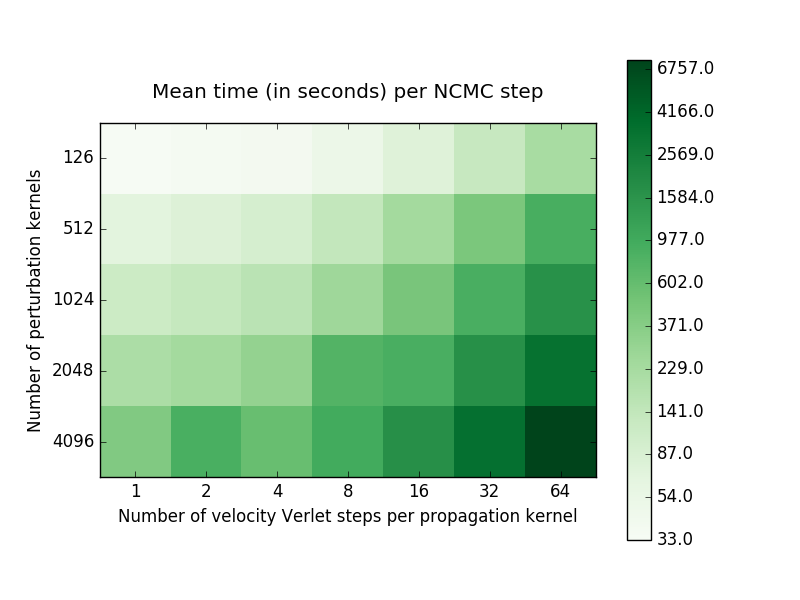

In [185]:
logtimes = np.log10(MeanTime)
lt = np.arange(np.min(logtimes),np.max(logtimes),0.21)
t = np.round(10**lt)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(logtimes,cmap=plt.cm.Greens,interpolation='none')
#fig.colorbar(cax)
fig.colorbar(cax,ticks=lt).set_ticklabels(t, update_ticks=True)

ax.set_xticklabels(['']+nvsteps)
ax.xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax.set_yticklabels(['']+nkernals)

ax.set_title('Mean time (in seconds) per NCMC step')
ax.set_ylabel("Number of perturbation kernels")    
ax.set_xlabel("Number of velocity Verlet steps per propagation kernel")       
ax.xaxis.set_label_position('bottom') 

#fig.set_title('Acceptance Probability')
plt.savefig("MeanTime.png", format='png')
Image("MeanTime.png")

# 2. Convergence analysis
Trying to determine whether each run is sampling from equilibrium by looking at correlation times. If they are decorrelated, then it suggests that my sampling scheme is biased.

In [177]:
from pymbar import timeseries as ts

Looking a 4 representative trajectories, and seeing if they appear sufficiently "equilibrated"

Number of uncorelated smaples (4096, 32) 40.6447463829
Number of uncorelated smaples (2048, 16) 113.005959262
Number of uncorelated smaples (1024, 8) 133.407009788
Number of uncorelated smaples (512, 4) 39.0702533299


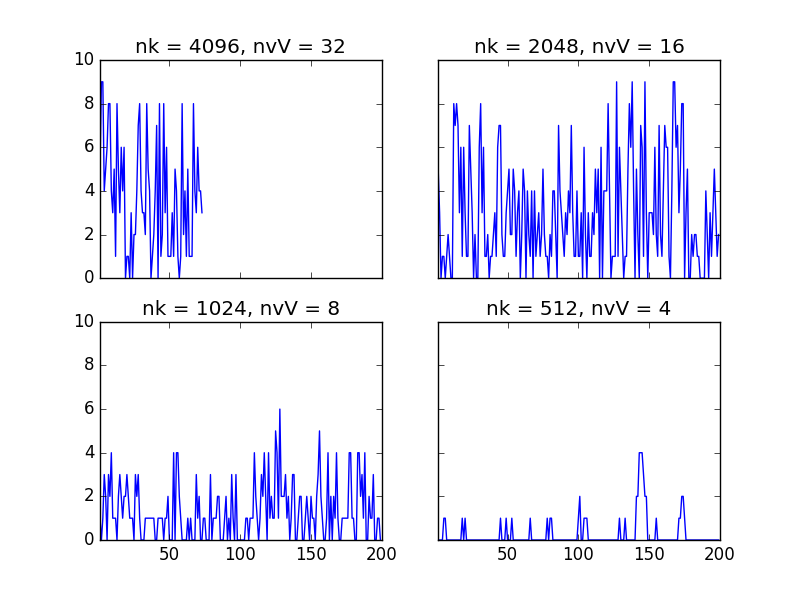

In [182]:
params = [(4096,32),(2048,16),(1024,8),(512,4)]
coords = [(0,0),(0,1),(1,0),(1,1)]

f, axarr = plt.subplots(2, 2)
xlims =(1,200)       # x limits
ylims = (0,10)       # y limits


for p,c in zip(params,coords):
    # Reading in data
    filename = 'NCMC_sweep/nk{0}_nV{1}/run1.txt'.format(p[0],p[1])
    nsalt = readdata(filename)[1]
    #time = np.arange(1,len(nsalt)+1) 
    time = range(len(nsalt))
    # Plotting
    axarr[c].plot(nsalt)
    axarr[c].set_xlim(xlims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_title('nk = {0}, nvV = {1}'.format(p[0],p[1]))
    ts.statisticalInefficiency(nsalt)
    print 'Number of uncorelated smaples', p,len(nsalt)/ts.statisticalInefficiency(nsalt)
    # Time series analysis doesn't work because of too many zeros in final plot
    #try:
    #stats = ts.detectEquilibration(nsalt) # Start of equil time, stat inefficiency, num uncorrelated sample
    #    axarr[c].axvline(x=stats[0],linewidth=2, color='k')
    #except ValueError:
    #    pass
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)  

plt.savefig("temp.png", format='png')
Image("temp.png")

Even though `detectEquilibration` breaks, they look like they are sampling from a different equilibrium distribution.

## 3. Work distributions

To do...